In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from manual_diff_augment import DiffAugment, rand_brightness, rand_cutout, rand_contrast, rand_saturation, make_rgb_to_gray, make_rgb_to_black
import dezero
from dezero import cuda
import dezero.functions as F
import dezero.layers as L
from dezero import DataLoader
from dezero.models import Sequential
from dezero.optimizers import Adam

In [3]:
use_gpu = cuda.gpu_enable
print(use_gpu)

True


In [4]:
dataset_A = np.load('../training_dataset/Domain_A_50_256x256.npy')
dataset_B = np.load('../training_dataset/Domain_B_50_256x256.npy')

data_A = []
data_B = []

for i in range(len(dataset_A)):
    reshaped = np.transpose(dataset_A[i], (2,0,1))
    data_A.append((reshaped, i))

for i in range(len(dataset_B)):
    reshaped = np.transpose(dataset_B[i], (2,0,1))
    data_B.append((reshaped, i))

dataloader_A = DataLoader(data_A, batch_size=32, shuffle=True)
dataloader_B = DataLoader(data_B, batch_size=32, shuffle=True)


In [5]:
#define generators
G_AB = Sequential(
    #encoding blocks
    L.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, pad=1, nobias=True),
    L.BatchNorm(),
    F.leaky_relu,

    L.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, pad=1, nobias=True),
    L.BatchNorm(),
    F.leaky_relu,

    #residual blocks
    L.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, pad=1, nobias=True),
    L.BatchNorm(),
    F.leaky_relu,

    L.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, pad=1, nobias=True),
    L.BatchNorm(),
    F.leaky_relu,

    #decoding blocks
    L.Deconv2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, pad=1, nobias=True),
    L.BatchNorm(),
    F.leaky_relu,

    L.Deconv2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, pad=1, nobias=True),
    L.BatchNorm(),
    F.tanh,
)

G_BA = Sequential(
    #encoding blocks
    L.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, pad=1, nobias=True),
    L.BatchNorm(),
    F.leaky_relu,

    L.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, pad=1, nobias=True),
    L.BatchNorm(),
    F.leaky_relu,

    #residual blocks
    L.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, pad=1, nobias=True),
    L.BatchNorm(),
    F.leaky_relu,

    L.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, pad=1, nobias=True),
    L.BatchNorm(),
    F.leaky_relu,

    #decoding blocks
    L.Deconv2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, pad=1, nobias=True),
    L.BatchNorm(),
    F.leaky_relu,

    L.Deconv2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, pad=1, nobias=True),
    L.BatchNorm(),
    F.tanh,
)


In [62]:
#define discriminator
D_A = Sequential(
    L.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, pad=1, nobias=True),
    L.BatchNorm(),
    F.leaky_relu,

    L.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, pad=1, nobias=True),
    L.BatchNorm(),
    F.leaky_relu,

    L.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, pad=1, nobias=True),
    L.BatchNorm(),
    F.leaky_relu,

    L.Conv2d(in_channels=256, out_channels=1, kernel_size=3, stride=1, pad=0, nobias=True),
    F.sigmoid,
)

D_B = Sequential(
    L.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, pad=1, nobias=True),
    L.BatchNorm(),
    F.leaky_relu,

    L.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, pad=1, nobias=True),
    L.BatchNorm(),
    F.leaky_relu,

    L.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, pad=1, nobias=True),
    L.BatchNorm(),
    F.leaky_relu,

    L.Conv2d(in_channels=256, out_channels=1, kernel_size=3, stride=1, pad=0, nobias=True),
    F.sigmoid,
)

In [63]:
if use_gpu:
    G_AB.to_gpu()
    G_BA.to_gpu()
    D_A.to_gpu()
    D_B.to_gpu()
    dataloader_A.to_gpu()
    dataloader_B.to_gpu()
    xp = cuda.cupy
else:
    xp = np

Generator A to B
shape: (8, 3, 256, 256)


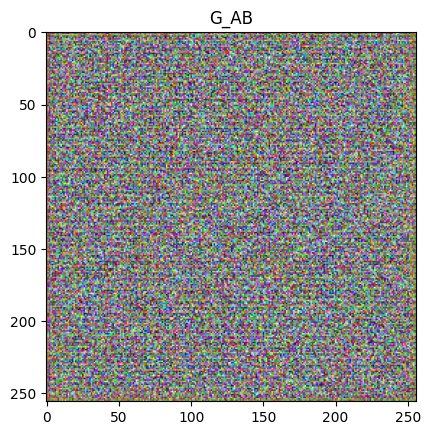

Generator B to A
shape: (8, 3, 256, 256)


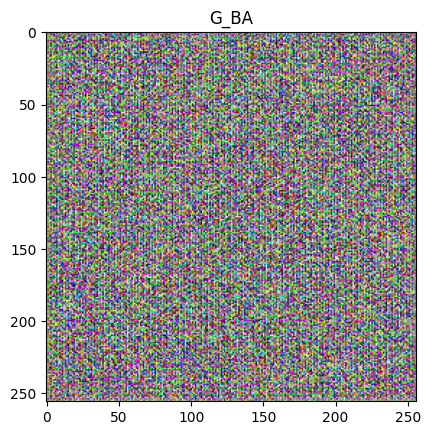

In [64]:
# Generator test
test_gx = xp.random.randn(8, 3, 256, 256) # test data

# test G_AB
test_pred_G_AB = G_AB(test_gx)
print("Generator A to B")
print("shape:", test_pred_G_AB.shape)
img = cuda.as_numpy(test_pred_G_AB.data)
img = (img + 1)/2
img = np.transpose(img, (0, 2, 3, 1))
plt.title("G_AB")
plt.imshow(img[0])
plt.show()

# test G_BA
test_pred_G_BA = G_BA(test_gx)
print("Generator B to A")
print("shape:", test_pred_G_BA.shape)
img = cuda.as_numpy(test_pred_G_BA.data)
img = (img + 1)/2
img = np.transpose(img, (0, 2, 3, 1))
plt.title("G_BA")
plt.imshow(img[0])
plt.show()

In [66]:
# Discriminator test
test_dx = xp.random.randn(8, 3, 256, 256) # test data

# test D_A
test_pred_D_A = D_A(test_dx)
print("Discriminator A")
print("shape:", test_pred_D_A.shape)

# test G_BA
test_pred_D_B = D_B(test_dx)
print("Discriminator B")
print("shape:", test_pred_D_B.shape)

Discriminator A
shape: (8, 1, 30, 30)
Discriminator B
shape: (8, 1, 30, 30)
